In [ ]:
import os

import kagglehub
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
from tqdm import tqdm

In [ ]:
data_dir = kagglehub.dataset_download(
    "siddhantmaji/unified-waste-classification-dataset"
)

print("Path to dataset files:", data_dir)

Path to dataset files: /kaggle/input/unified-waste-classification-dataset


In [ ]:
data_dir = f"{data_dir}/content/unified_dataset"
BATCH_SIZE = 32
IMG_SIZE = 224

# Preprocessing transforms only, no data augmentation
transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Load full dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Stratified train/val split
targets = [sample[1] for sample in dataset.samples]
train_idx, val_idx = train_test_split(
    range(len(dataset)), test_size=0.2, stratify=targets, random_state=42
)

train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v3_large(pretrained=True)
# Replace classifier's last layer to match number of classes
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 8)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 106MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
EPOCHS = 10

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
all_val_preds = []
all_val_labels = []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
        f"Epoch {epoch+1}: "
        f"Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.2f}% | "
        f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.2f}%"
    )

Epoch 1/10: 100%|██████████| 1600/1600 [07:07<00:00,  3.75it/s]


Epoch 1: Train Loss = 0.3517, Train Acc = 88.52% | Val Loss = 0.1205, Val Acc = 96.11%


Epoch 2/10: 100%|██████████| 1600/1600 [03:57<00:00,  6.73it/s]


Epoch 2: Train Loss = 0.1095, Train Acc = 96.40% | Val Loss = 0.0908, Val Acc = 97.30%


Epoch 3/10: 100%|██████████| 1600/1600 [04:03<00:00,  6.58it/s]


Epoch 3: Train Loss = 0.0614, Train Acc = 97.98% | Val Loss = 0.0876, Val Acc = 97.31%


Epoch 4/10: 100%|██████████| 1600/1600 [03:58<00:00,  6.70it/s]


Epoch 4: Train Loss = 0.0433, Train Acc = 98.57% | Val Loss = 0.0900, Val Acc = 97.56%


Epoch 5/10: 100%|██████████| 1600/1600 [03:57<00:00,  6.74it/s]


Epoch 5: Train Loss = 0.0327, Train Acc = 98.80% | Val Loss = 0.0806, Val Acc = 97.71%


Epoch 6/10: 100%|██████████| 1600/1600 [03:52<00:00,  6.88it/s]


Epoch 6: Train Loss = 0.0307, Train Acc = 98.99% | Val Loss = 0.0807, Val Acc = 97.72%


Epoch 7/10: 100%|██████████| 1600/1600 [03:53<00:00,  6.86it/s]


Epoch 7: Train Loss = 0.0233, Train Acc = 99.27% | Val Loss = 0.0853, Val Acc = 97.80%


Epoch 8/10: 100%|██████████| 1600/1600 [04:00<00:00,  6.66it/s]


Epoch 8: Train Loss = 0.0230, Train Acc = 99.23% | Val Loss = 0.0856, Val Acc = 97.81%


Epoch 9/10: 100%|██████████| 1600/1600 [03:54<00:00,  6.82it/s]


Epoch 9: Train Loss = 0.0212, Train Acc = 99.29% | Val Loss = 0.0924, Val Acc = 97.61%


Epoch 10/10: 100%|██████████| 1600/1600 [03:54<00:00,  6.83it/s]


Epoch 10: Train Loss = 0.0176, Train Acc = 99.42% | Val Loss = 0.0873, Val Acc = 97.96%


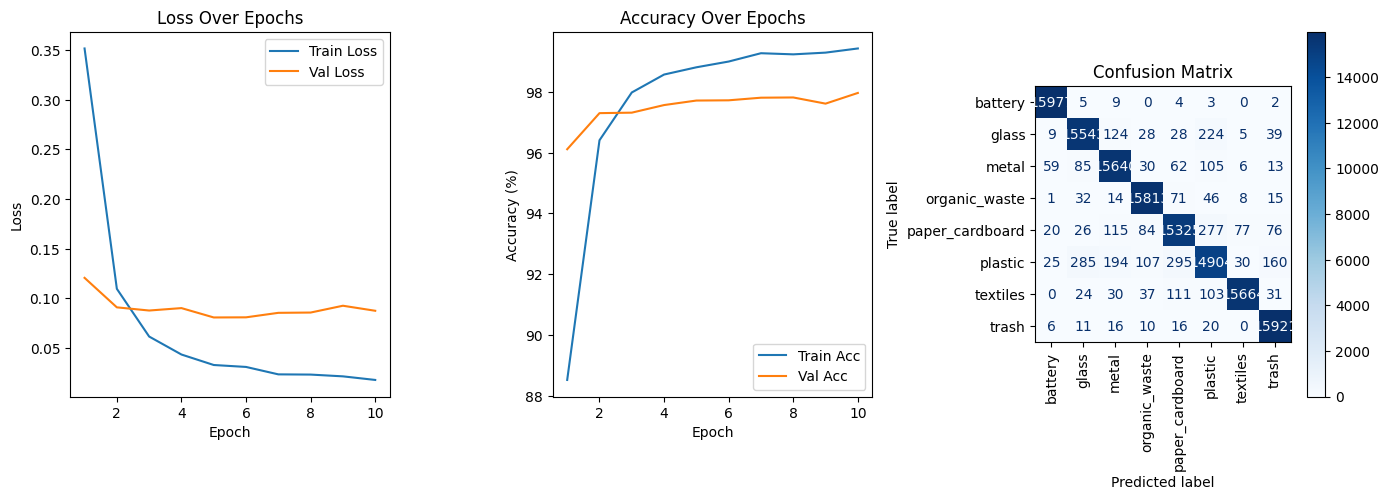

In [ ]:
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(14, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracies, label="Train Acc")
plt.plot(epochs_range, val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Epochs")
plt.legend()

# Confusion Matrix
plt.subplot(1, 3, 3)
cm = confusion_matrix(all_val_labels, all_val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap="Blues", values_format="d", ax=plt.gca())
plt.xticks(rotation=90)
plt.title("Confusion Matrix")

plt.tight_layout()
plt.savefig("../outputs/mobilenetv3_garbage_classifier_results.png")
plt.show()

In [ ]:
model.cpu()
model.eval()

model.qconfig = torch.quantization.get_default_qconfig("qnnpack")
torch.quantization.prepare(model, inplace=True)

num_samples = 0
max_samples = 500

with torch.no_grad():
    for images, _ in val_loader:
        batch_size = images.size(0)
        model(images)
        num_samples += batch_size
        if num_samples >= max_samples:
            break

torch.quantization.convert(model, inplace=True)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): QuantizedConv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), scale=0.4364759027957916, zero_point=129, padding=(1, 1), bias=False)
      (1): QuantizedBatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): QuantizedHardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): QuantizedConv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.5667265057563782, zero_point=74, padding=(1, 1), groups=16, bias=False)
          (1): QuantizedBatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): QuantizedConv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), scale=0.1259629726409912, zero_point=124, bias=False)
          (1): QuantizedBatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=T

In [ ]:
scripted_model = torch.jit.script(model)
scripted_model.save("../models/mobilenetv3_garbage_classifier_quantized.pt")

# from google.colab import files

# files.download("mobilenetv3_garbage_classifier_quantized.pt")
# files.download("mobilenetv3_garbage_classifier_results.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>